# Lecture 13: AM Circuits and Homodyne Radios

EE-40453, Digital Radio Communications, Spring 2020

J. Nicholas Laneman, Bertrand Hochwald, & Jonathan Chisum<br>
Wireless Institute & Department of Electrical Engineering<br>
University of Notre Dame

Copyright 2020, All Rights Reserved

## Summary

In this lecture, we will call out a number of assumptions that we made in our "idealized" treatment of various AM modulation and demodulation techniques, and explore how closely practical circuit implementations can approach the ideal.

## Motivation in Course Context

In various AM modulations and demodulations, we incorporated multiplication by a sinusoidal carrier signal to affect frequecny translation. The figure below illustrates how we translate this signals and systems concept into practical circuits, specifically with two key modules: an *oscillator* and a *mixer*.

<img src="images/01.png" width="80%">

You will take your first crack at working with oscillators and mixers in your next lab, and we will continue to address various impairments and design tradeoffs that arise over the course of the next few labs.

## Outline

* Oscillators

* Mixers

## Oscillators

For our purposes, an oscillator will be any circuit module that can generate a relatively steady, sinusoidal signal of a given frequency.

### Linear Feedback Oscillators

There are many circuit implementations of oscillators; however, at the signals systems level, we can model an oscillator as an amplifier connected in a positive feedback loop as shown in the figure below.

<img src="images/02.png" width="80%">

For radio applications, the feedback filter is often modeled as a *tuned circuit* or *tank circuit* consisting of an inductors and capacitors connected together to be resonsant at the desired frequency $f_c$. Beyond discrete inductor and capactitor circuits, tuned circuit can be implemented using sevreal other technologies, including piezoelectric crystal such as quartz, dielectric resonators, and surface acoustic wave (SAW) devices. Although there are resistive losses in the tuned circuit itself, the amplifier configured in the feedback loop compensates for the losses and provides the power for the output.

To ensure marginally stable oscillations at the desired frequency, the open-loop gain must satisfy $|G(f_c)H(f_c)|\simeq 1$ and the phase $\angle(G(f_c) H(f_c))\simeq 2\pi$.

### Voltage Controlled Oscillators (VCO)

To allow an oscillator output frequency to vary over some desired range by a control voltage. Such an oscillator is naturally called a *voltage controlled oscillators (VCO)*. The most common way to implement a VCO is by adding a varactor diode to the tuned circuit or resonator in an oscillator circuit. Changing the voltage across the varactor changes its effective capacitance, which in turn affects the resonant frequency.

At the signals and systems level, the VCO can be modeled as shown in the figure below

<img src="images/03.png" width="80%">

where $f_q$ is called the *quiescent frequency* of the VCO, and the output phase of the carrier signal is related to the input voltage $v_{\mathrm{in}}(t)$ as

$$\vartheta(t) = k \int_{-\infty}^{t} v_{\mathrm{in}}(\tau) d\tau$$

and $k$ is the gain of the VCO.

#### DC Input

If we apply a constant (DC) voltage $v_{\mathrm{in}}(t)=V_0$ at the input to the VCO, then $\vartheta(t)=kV_0 t$. Generating a desired output frequency $f_c$ thus requires

$$f_c = f_q + \frac{kV_0}{2\pi}$$

or

$$V_0 = 2\pi \left(\frac{f_c - f_q}{k}\right)$$

Any given VCO will have specifications for the allowable range of input voltages and their corresponding output frequences relative to the quiescent frequency.

#### General Input

More generally, if $v_{\mathrm{in}}(t)$ is not a constant voltage input, then the output frequency of the oscillator will not be constant. The *instantaneous frequency* of the output sinusoid is defined as the normalized derivative of the argument to the sinusoid, i.e.

$$\begin{align}
f_i(t) &= f_q + \frac{1}{2\pi} \frac{d}{dt} \vartheta(t) \\
&= f_q + \frac{1}{2\pi} k\ v_{\mathrm{in}}(t)
\end{align}$$

As an aside, this relationship is the basis of another modulation technique called *frequency modulation (FM)*. However, if we want to generate a sinusoidal signal for use in amplitude modulation, then we want the output frequency to be as stable as possible. As a result, we often utilize a regulate voltage input and bypass capacitors at both the power and $v_{\mathrm{in}}(t)$ inputs on a VCO.

### Additional Information

For many more details about oscillator circuits, please see:

* https://en.wikipedia.org/wiki/Electronic_oscillator
* https://www.minicircuits.com/appdoc/AN95-007.html

**Example**: A simple PLL example

In [2]:
import numpy as np
import pdb
import matplotlib.pylab as plt 

In [3]:
class SimplePLL(object):
    def __init__(self, lf_bandwidth):
        self.phase  = 0 
        self.freq  = 0 
        self.vco = np.exp(1j*self.phase )
        self.phase_difference = 0
        self.bw = lf_bandwidth
        self.beta = np.sqrt(lf_bandwidth)

    def update_vco(self):
        self.vco = np.exp(1j*self.phase)

    def update_phase_difference(self, input):
        self.phase_difference = np.angle(input*np.conj(self.vco))

    def update(self, input):
        # Takes an instantaneous sample of a signal and updates the PLL's inner state
        self.update_phase_difference(input)
        self.freq += self.bw * self.phase_difference
        self.phase  += self.beta * self.phase_difference + self.freq 
        self.update_vco()

In [4]:
pll = SimplePLL(1e-3)
ref = []
out = []
diff = []
    
fs = 1000 #MHz 
fc = 10 #MHz
N = int(5*fs)
n = np.arange(N,dtype = int)
t = n/fs
ref = np.exp(1j*2*np.pi*fc*t)

for i in range(0, N):
    input = ref[i]
    pll.update(input)
    out.append(pll.vco)
    diff.append(pll.phase_difference)

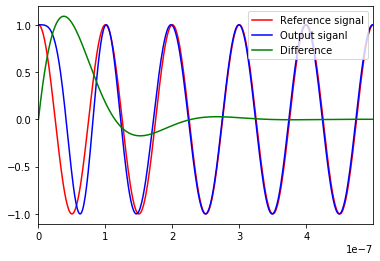

In [6]:
plt.plot(t/1e6,np.real(ref),'r',label = "Reference signal")
plt.plot(t/1e6,np.real(out),'b',label = "Output siganl")
plt.plot(t/1e6,diff,'g',label = "Difference")
plt.xlim(0, np.max(t)/1e7)
plt.legend()
plt.show()

## Mixers

Mixers are circuits that approximate the mathematical operation of multiplication of two signals, but they generally require that the signals be either baseband or passband signals to work effectively. As we will see, mixers can require filtering of the inputs and outputs to ensure that unwanted harmonics and intermodulation products are adequately suppressed.

[comment]: # (From http://164.100.133.129:81/econtent/Uploads/Session%205.pdf)

More specifically, a mixer is a non-linear or time-varying device that accepts at its input two signals centered at two different frequencies, e.g., $f_{\mathrm{in}}$ and $f_{\mathrm{lo}}$, and generates at its output a mixture of signals centered at various frequencies, e.g.,

* Desired outputs such as $f_{\mathrm{in}} \pm f_{\mathrm{lo}}$

* Undesired intermodulation products such as $m f_{\mathrm{in}} \pm n f_{\mathrm{lo}}$, for $m,n \neq 1$

### Simple Diode Mixer

To illustrate the general idea, consider at the signals and systems level a circuit that adds the input and LO signals and applies them to the input of a diode as shown in the figure below.

<img src="images/04.png" width="80%">

Recall that the current voltage relationship for the diode is given by

$$i_{\mathrm{d}}(t) = I_S \left(e^{\frac{v_{\mathrm{d}}(t)}{n V_T}} - 1 \right)$$

where $I_s$ (reverse bias saturation current), $V_T$ (thermal voltage), and $n$ (quality factor) are parameters of the specific device. The output voltage will be proportional to the current through the diode.

For small arguments $x$, the non-linear relation $e^x-1$ can be approximated by

$$e^x-1 \approx x + \frac{x^2}{2}$$

Thus, if we substitute $v_{\mathrm{d}}(t)=v_{\mathrm{in}}(t)+v_{\mathrm{lo}}(t)$ into the approximation and expand, we will have

$$\begin{align}
v_{\mathrm{out}}(t) &\approx A \left(v_{\mathrm{in}}(t)+v_{\mathrm{lo}}(t)\right) + B \left(v_{\mathrm{in}}(t)+v_{\mathrm{lo}}(t) \right)^2 \\
&= A \left(v_{\mathrm{in}}(t)+v_{\mathrm{lo}}(t)\right) + B \left(v_{\mathrm{in}}(t) v_{\mathrm{lo}}(t) + v^2_{\mathrm{in}}(t) + v^2_{\mathrm{lo}}(t) \right)
\end{align}$$

and, for simplicity of exposition, we will ignore the constants $A$ and $B$ for the remainder of the discussion.

With this approximation, we see that the output has three kinds of terms

* The desired multiplication of the input and local oscillator signals, i.e., $v_{\mathrm{in}}(t) v_{\mathrm{lo}}(t)$

* The undesired input and local oscillator signals individually, i.e., $v_{\mathrm{in}}(t)$ and $v_{\mathrm{lo}}(t)$, which are referred to as *input leakage* and *local oscillator leakage*, respectively

* The undesired quadratic terms of the input and local oscillator signals individually, i.e., $v^2_{\mathrm{in}}(t)$ and $v^2_{\mathrm{lo}}(t)$, which are referred to as *input self-mixing* and *local oscillator self-mixing*, respectively

With a higher-order (Taylor series) approximation to the diode IV characteristic, we could track mixing products between the input and local oscillator for which the sum of the powers of the terms is greater than two.

**TBD: Simplest possible diode mixer circuit for baseband signal modulated to ISM band.**

### Impacts on Transmitter Design

In the radio transmitter we are currently considering, the mixer input is a baseband signal $v_{\mathrm{in}}(t)=v_{\mathrm{bb}}(t)$, and the local oscilllator input is $v_{\mathrm{lo}}(t)=\cos(2\pi f_c t)$.

The simple mixer output in this case will include terms such as

* The desired output proportional to $v_{\mathrm{bb}}(t) \cos(2\pi f_c t)$, centered at frequency $f_c$

* The leaked signals proportional to $v_{\mathrm{bb}}(t)$ and $\cos(2\pi f_c t)$, centered at DC and frequency $f_c$, respectively

* The self-mixing terms proportional to $v^2_{\mathrm{bb}}(t)$ and $\cos^2(2\pi f_c t)=\frac{1}{2}[1+\cos(2\pi(2f_c) t)]$, centered at DC (but with twice the bandwidth) and $2f_c$, respectively.

**TBD: Example spectrum sketch**

**Example**

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pylab as plt 
from scipy import fftpack

In [21]:
# vin = cos(2*pi*f_in*t)
# vlo = cos(2*pi*f_c*t)
# ignore A,B

f0 = 1e2
fc = 5e2
fs = 5e3
N = int(1e7)

n = np.arange(N,dtype=int)
t = n/fs 
vlo = np.cos(2*np.pi*fc*n/fs)


T = 1/f0
Ts = 1/fs
x = np.zeros( (N,) ) 


x[1*int(T/Ts):2*int(T/Ts)] = 1.0

vin = f0*x

vout = vin + vlo + vin*vlo + vin*vin + vlo*vlo 

vinf = fftpack.fftshift(fftpack.fft(vin))
vlof = fftpack.fftshift(fftpack.fft(vlo))
voutf = fftpack.fftshift(fftpack.fft(vout))
freq = np.linspace(-1/2, 1/2, num = N)

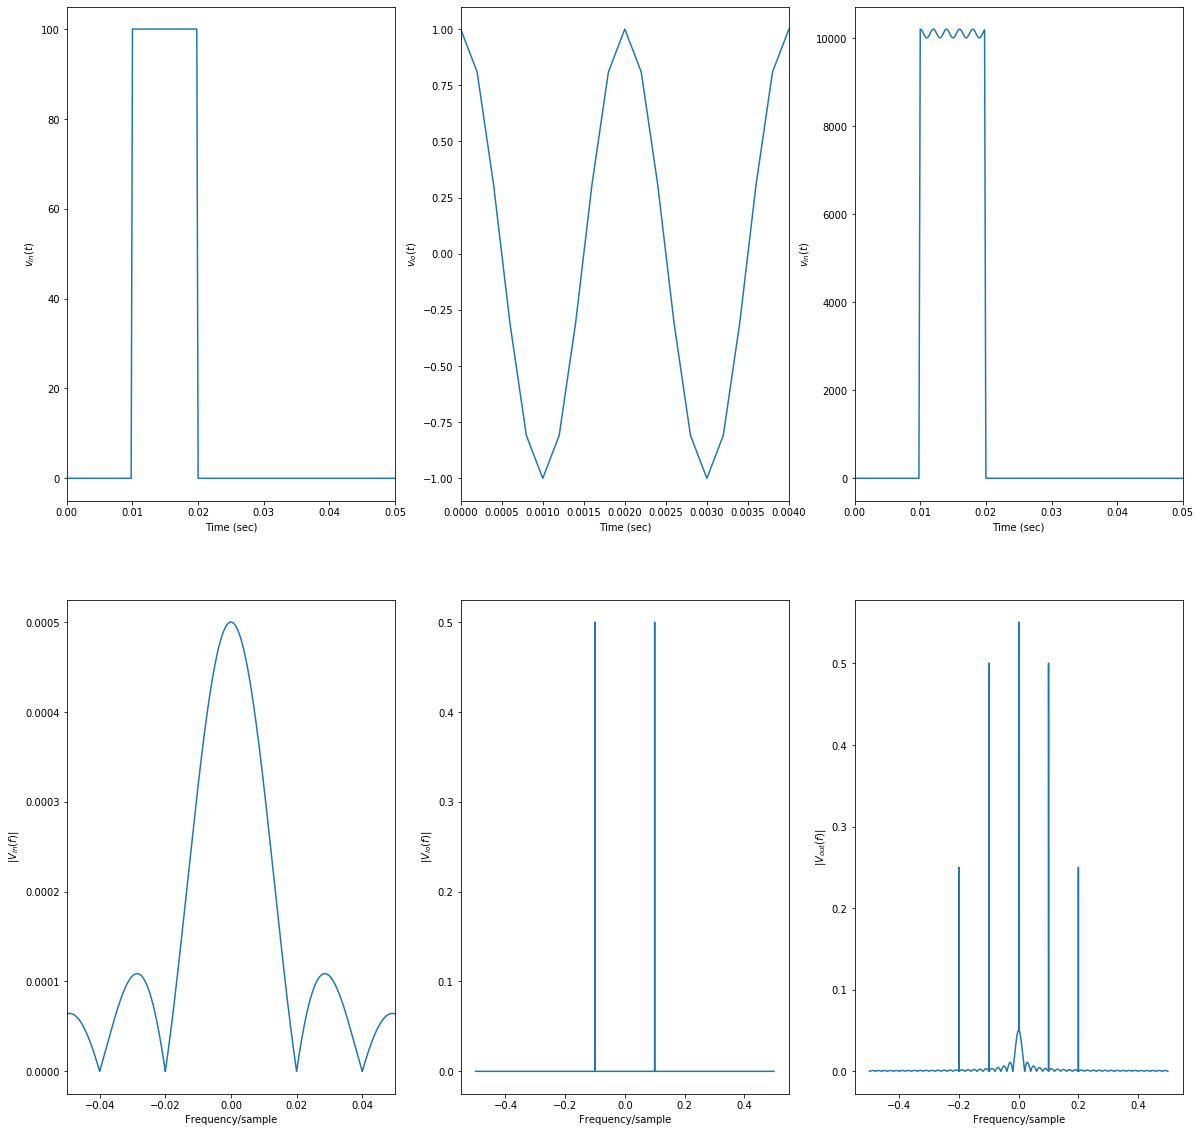

In [22]:
f = plt.figure()
f.set_figheight(20)
f.set_figwidth(20)

plt.subplot(231)
plt.plot(t, vin)
plt.xlabel("Time (sec)")
plt.ylabel("$v_{in}(t)$")
plt.xlim(0,5/f0)

plt.subplot(232)
plt.plot(t, vlo)
plt.xlabel("Time (sec)")
plt.ylabel("$v_{lo}(t)$")
plt.xlim(0,2/fc)

plt.subplot(233)
plt.plot(t, vout)
plt.xlabel("Time (sec)")
plt.ylabel("$v_{in}(t)$")
plt.xlim(0,5/f0)


plt.subplot(234)
plt.plot(freq, (abs(vinf)/N),'-')
plt.ylabel("$|V_{in}(f)|$")
plt.xlabel("Frequency/sample")
plt.xlim(-2.5*f0/fs,2.5*f0/fs)

plt.subplot(235)
plt.plot(freq,abs(vlof)/N,'-')
plt.ylabel("$|V_{lo}(f)|$")
plt.xlabel("Frequency/sample")

plt.subplot(236)
plt.plot(freq, (abs(voutf)/N),'-')
plt.ylabel("$|V_{out}(f)|$")
plt.xlabel("Frequency/sample")

plt.show()

Clearly, a bandpass filter centered at the desired carrier output frequency and passband bandwidth less than $f_c$ will reduce the inpact of the terms centered at DC as well as at $2f_c$. In fact, an antenna tuned to our target frequency will significantly reduce the impact of these terms. **However, neither the antenna nor additional bandpass filtering can address the LO leakage term.**

To reduce the effect of LO leakage in our desired passband, we can improve the design through a combination of technques, including:

* Balancing the mixer's response to the local oscillator (later today)

* Utilizing two or more stages of upconversion to separate leaked LO frequency from the desired passband frequency $f_c$, so that the LO leakage can be filtered out as well (starting Friday)

### Impacts on Receiver Design

In the radio receiver we are currently considering, the mixer input is the RF signal $v_{\mathrm{rf}}(t)$ centered at the carrier $f_c$, and the local oscillator is again of the form $v_{\mathrm{lo}}(t)=\cos(2\pi f_c t)$. Ideally, $v_{\mathrm{rf}}(t) \propto m(t)\cos(2\pi f_c t)$, where $m(t)$ is the modulating signal.

The simple mixer output in this case will include terms such as 

* The desired output propotional to $v_{\mathrm{rf}}(t) \cos(2\pi f_c t)$, with components centered at DC and centered at frequency $2f_c$

* The leaked signals proportional to $v_{\mathrm{rf}}(t)$ and $\cos(2\pi f_c t)$, both centered at $f_c$

* The self-mixing terms proportional to $v^2_{\mathrm{rf}}(t)$ and $\cos^2(2\pi f_c t)=\frac{1}{2}[1+\cos(2\pi(2f_c) t)]$, with components centered at DC (but with twice the bandwidth) and $2f_c$, respectively.

**TBD: Example spectrum sketch**

Recall that for various AM demodulations, we placed a lowpass filter at the output of the mixer intended to eliminate terms centered at $2f_c$. The observations above suggest that we may want a narrower lowpass filter to eliminate the terms centered at $f_c$ as well. **However, the lowpass filter will not be able to eliminate the self-mixing terms centered at DC, or the potential DC offset.** Since a receiver $v_{\mathrm{rf}}(t)$ is assumed to be small, we can hope that $v^2_{\mathrm{rf}}(t)$ is very small. So we mainly have to be concerned with the LO self-mixing term, which leads to a DC offset.

To reduce the effect of DC offset in our desired output, we can improve the design through a combination of technques, including:

* AC coupling the output of the mixer, provided we take such a "notch filter" into account in our design of the modulating signal $m(t)$

* Utilizing two or more stages of downconversion to separate desired mixer output from DC, so that the DC component can be filtered out (starting Friday)

### Additional Information

For many more details about mixer circuits, please see:

* https://en.wikipedia.org/wiki/Frequency_mixer
* https://www.minicircuits.com/appdoc/AN00-009.html

## Balancing Acts

We identified leakage terms in the output of the simple mixer above. These can be reduced significantly through a technique called *balancing*. We illustrate balancing the response of a mixer to the local oscillator input, as shown in the diagram below.

[comment]: # (From Lathi and Ding, Fig. 4.3)

<img src="images/05.png" width="80%">

Here we see that we have two simple mixer circuits, and we can apply the simple approximations both of them. When we do so, we will observe that leaked local oscillator signals with the same polarity that are canceled in the final stage. The leaked input and product terms have opposite polarities, and one is negated in the final stage, so that they add up.

This example illustrates perfect cancellation of the local oscillator leakage. In a practical mixer, the local oscillator leakage will be partially canceled through balancing, but not completely canceled because of small differences in the circuit components.

## Putting it All Together

Given our modulation approach and circuit approximations to this point, we can build what is called a *homodyne* radio transmitter and recevier pair.

<img src="images/06.png" width="80%">

Although we have come a long way toward building a radio that can take advantage of wireless transmission using antennas and electromagnetic waves, this radio design has three significant issues that still need to be addressed:

* LO leakage from the transmit mixer

* LO self-mixing that leads to DC offsets in the receive mixer

* Frequency and phase differences between the transmit and receive oscillators

We build and explore the limitations of such radios in lab, and then spend a few weeks addressing each of these issues above through improvements in the radio designs.

**Example**

Assume that a DSB signal $𝑥_𝑐 (𝑡) = 𝐴_𝑐 𝑚(𝑡) \cos(2\pi𝑓_𝑐 𝑡 + \phi_0)$ is demodulated using the demodulation carrier $2 \cos(2\pi𝑓_𝑐 𝑡 + \theta(𝑡))$. Determine, in general, the demodulated output $𝑦_𝐷(𝑡)$.

<!--
    Source: Principles of Communications, 7th edition, Ziemer, 3.1 
    URL: https://physicaeducator.files.wordpress.com/2018/03/principles-of-communications-7th-edition-ziemer.pdf
    Author: R. E. Ziemer and W. H. Tranter
    Answer: 
-->

Solution:

\begin{align}
y_D(t) & = x_c(t) 2\cos[2\pi𝑓_𝑐 𝑡 + \theta(𝑡)]\\
& = 𝐴_𝑐 𝑚(𝑡) \cos(2\pi𝑓_𝑐 𝑡 + \phi_0) \cdot 2\cos(2\pi𝑓_𝑐 𝑡 + \theta(𝑡))\\
& = 𝐴_𝑐 𝑚(𝑡) \left( \cos(2\pi𝑓_𝑐 𝑡 + \phi_0 + 2\pi𝑓_𝑐 𝑡 + \theta(𝑡)) + \cos( 2\pi𝑓_𝑐 𝑡 + \phi_0 - 2\pi𝑓_𝑐 𝑡 - \theta(𝑡))\right), \text{ by } 2\cos A \cos B = \cos(A+B) + \cos(A-B)\\
& = 𝐴_𝑐 𝑚(𝑡) \left( \cos(4\pi𝑓_𝑐 𝑡 + \phi_0 + \theta(𝑡)) + \cos( \theta(𝑡) - \phi_0 )\right)
\end{align}